#### Code based on the article: https://arxiv.org/abs/1903.10176
## Important Note:
Our algorithm integrates BM3D as RED engine with DIP network.

Follow these 3 steps:
    1. download the BM3D code: http://www.cs.tut.fi/~foi/GCF-BM3D/ and put in "matlab_codes" folder
    2. Download and install the Matlab engine, see:
        https://www.mathworks.com/help/matlab/matlab_external/install-matlab-engine-api-for-python-in-nondefault-locations.html
    3. Edit the BM3D Matlab code (and the wrapper function), so you will be able to use it an external denoiser. 
        We are saving arrays as ".npy" and reading them in Matlab code.
        We found that it's the fastest way to work. Working this way requires the code:
        https://github.com/kwikteam/npy-matlab
        just put all *. files in matlab_codes folder. You may work with ".mat" instead (it's a bit slower tho).

# Import libs

In [1]:
import os
from threading import Thread  # needed since the denoiser is running in parallel
import queue

import numpy as np
import torch
import torch.optim
from models.skip import skip  # our network

from utils.utils import *  # auxiliary functions
from utils.data import Data  # class that holds img, psnr, time
from models.downsampler import Downsampler

from skimage.restoration import denoise_nl_means, estimate_sigma

In [2]:
# Load Matlab:
from utils.matlab_utils import *
os.environ['TMP'] = r'tmp'
os.environ['TEMP'] = r'tmp'
prevdir = os.getcwd()
os.chdir("matlab_codes/")  # make sure all the matlab codes are in this directory
eng = matlab.engine.start_matlab("-nojvm")  # this may take a while. To close session use: eng.quit()
os.chdir(prevdir)
print("Successfully loaded", eng)

Successfully loaded <matlab.engine.matlabengine.MatlabEngine object at 0x000001F401DCF880>


In [3]:
CUDA_FLAG = False  # got GPU?
CUDNN = False  # if you are not getting the exact article results set CUDNN to False
if CUDA_FLAG:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # GPU accelerated functionality for common operations in deep neural nets
    torch.backends.cudnn.enabled = CUDNN
    # benchmark mode is good whenever your input sizes for your network do not vary.
    # This way, cudnn will look for the optimal set of algorithms for that particular 
    # configuration (which takes some time). This usually leads to faster runtime.
    # But if your input sizes changes at each iteration, then cudnn will benchmark every
    # time a new size appears, possibly leading to worse runtime performances.
    torch.backends.cudnn.benchmark = CUDNN
    # torch.backends.cudnn.deterministic = True
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# Constants

In [4]:
FACTOR = 4  # scale factor, factor > 1, org HR -> LR --train--> est HR, compare psnr with org HR vs est HR on Y. ch
            #               factor < 1, LR --train--> est HR, in that case ignore the psnrs, and enjoy your image
# Algorithm NAMES (to get the relevant image: use data_dict[alg_name].img)
# for example use data_dict['Clean'].img to get the clean image
ORIGINAL  = 'HR'
CORRUPTED = 'LR'
BICUBIC   = 'Bicubic'
DIP_BM3D  = 'DRED (BM3D)' 

# Load image for Super-Resolution

In [5]:
def load_LR_HR_imgs_sr(fname, factor, use_matlab_resize=False, plot=False):  # matlab_resize requires matlab engine
    """  Loads an image, resize it, center crops and upscale / downscales depends on factor (i.e > 1 or < 1)
    Args: 
         fname: path to the image
         factor: downscaling factor, you can pass factors smaller than 1 (i.e 0.25) it will scale up
    Out:
         dictionary of 3 kinds of images: 'LR', 'HR', 'Bicubic', # you may add: 'Sharp', 'Nearest'
    """
    if factor > 1:  # we have the original (HR) image, lets get the LR image
        img_HR_pil, img_HR_np = load_and_crop_image(fname, d=factor)  # crop by factor
        if use_matlab_resize:
            img_LR_pil, img_LR_np = matlab_resize(eng, img_HR_np, 1. / factor)
        else:
            img_LR_pil, img_LR_np = pil_resize(img_HR_pil, factor)
    else:  # we have the small image, lets get the HR image
        img_LR_pil, img_LR_np = load_and_crop_image(fname)
        if use_matlab_resize:
            img_HR_pil, img_HR_np = matlab_resize(eng, img_LR_np, 1. / factor)
        else:
            img_HR_pil, img_HR_np = pil_resize(img_LR_pil, int(1 // factor), downscale=False)
    # Gets `bicubic` baseline
    img_bicubic_pil = img_LR_pil.resize(img_HR_pil.size, Image.BICUBIC)
    img_bicubic_np = pil_to_np(img_bicubic_pil)
    data_dict = {ORIGINAL: Data(img_HR_np), CORRUPTED: Data(img_LR_np),
                 BICUBIC: Data(img_bicubic_np, compare_psnr_y(img_HR_pil, img_bicubic_pil))
                 }
    if plot:
        print('HR and LR resolutions:', img_HR_np.shape, img_LR_np.shape)
        plot_dict(data_dict)
    return data_dict


HR and LR resolutions: (3, 256, 256) (3, 64, 64)


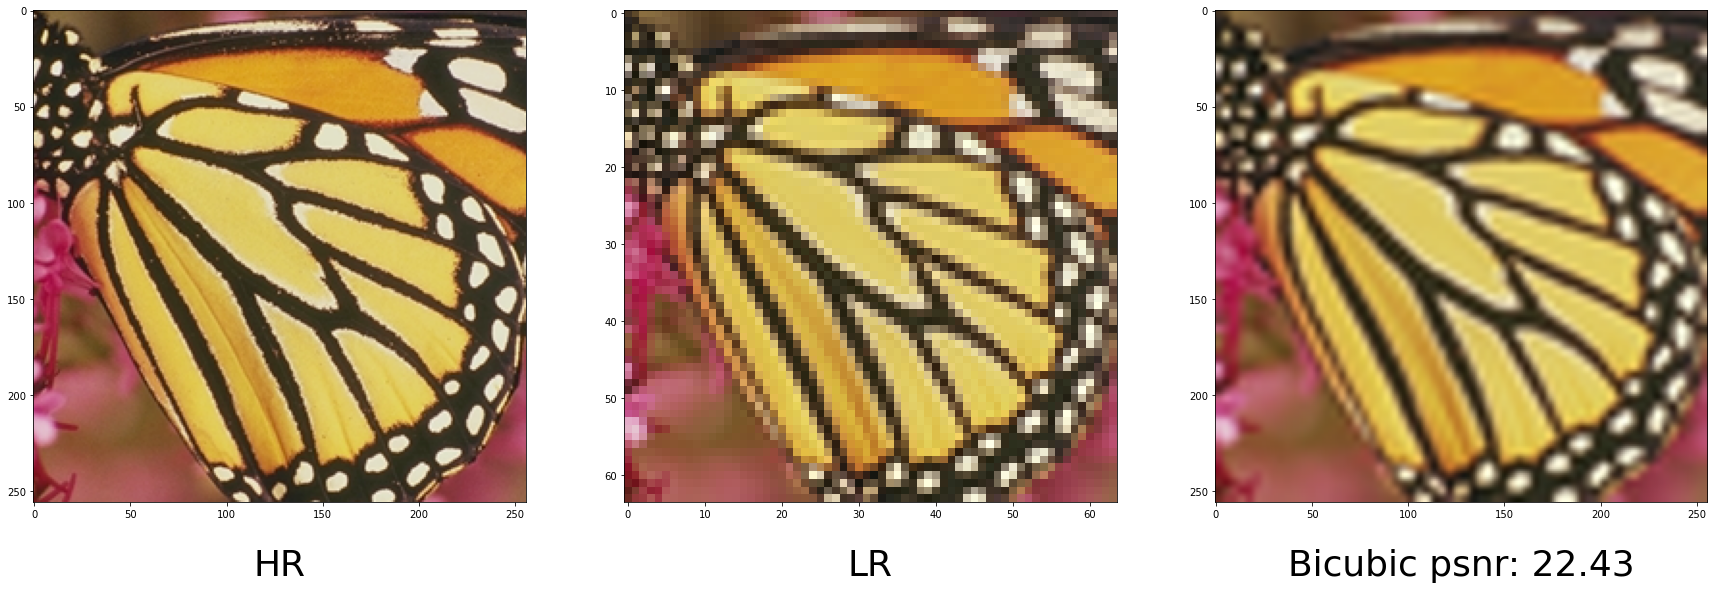

In [6]:
# Get the LR and HR images
data_dict = load_LR_HR_imgs_sr('545test_set/butterfly.png', factor=FACTOR, plot=True)
if FACTOR < 1:
    FACTOR = int(1 // FACTOR)  # after loaded, we fix the factor so other algorithm will work

# THE NETWORK

In [7]:
def get_network_and_input(img_shape, input_depth=32, pad='reflection',
                          upsample_mode='bilinear', use_interpolate=True, align_corners=False,
                          act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4,
                          num_scales=5, downsample_mode='stride', INPUT='noise'):  # 'meshgrid'
    """ Getting the relevant network and network input (based on the image shape and input depth)
        We are using the same default params as in DIP article
        img_shape - the image shape (ch, x, y)
    """
    n_channels = img_shape[0]
    net = skip(input_depth, n_channels,
               num_channels_down=[skip_n33d] * num_scales if isinstance(skip_n33d, int) else skip_n33d,
               num_channels_up=[skip_n33u] * num_scales if isinstance(skip_n33u, int) else skip_n33u,
               num_channels_skip=[skip_n11] * num_scales if isinstance(skip_n11, int) else skip_n11,
               upsample_mode=upsample_mode, use_interpolate=use_interpolate, align_corners=align_corners,
               downsample_mode=downsample_mode, need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun).type(dtype)
    net_input = get_noise(input_depth, INPUT, img_shape[1:]).type(dtype).detach()
    return net, net_input

## BM3D denoiser (This wrapper function for the original Matlab code)
#### make sure you edit the original code to work with this function / or alternatively create your own wrapper

In [8]:
def bm3d(noisy_np_img, sigma):
    np.save('matlab_codes/noisy.npy', noisy_np_img.transpose(1, 2, 0))
    if noisy_np_img.shape[0] == 3:  # Color BM3D (3D)
        eng.CBM3D(noisy_np_img, float(sigma), 'np', 'opp', nargout=3)
        denoised_img = np.load('matlab_codes/denoised.npy').astype(np.float32)
        return denoised_img.transpose(2, 0, 1)
    # 2D BM3D:
    eng.BM3D_denoise(float(sigma), nargout=0)
    return np.expand_dims(np.load('matlab_codes/denoised.npy').astype(np.float32), axis=0)

# Deep Learning Powered by RED, Our Generic Function
## The RED engine with Neural Network
## you may test it with any neural net, and any denoiser

In [9]:
def train_via_admm(net, net_input, denoiser_function, D, y, bicubic, HR_img=None,  # D is the downsampler, y is LR image
                   plot_array={}, algorithm_name="", save_path="",          # will save params and graphs in this folder
                   admm_iter=2000, LR=0.001, update_iter=10, method='fixed_point',   # 'fixed_point' or 'grad' or 'mixed'
                   sigma_f=5, beta=0.05, mu=0.06, LR_x=None, noise_factor=.02):    # LR_x needed only if method!=fixed_point
    """ training the network using
        ## Must Params ##
        net                 - the network to be trained
        net_input           - the network input
        denoiser_function   - an external denoiser function, used as black box, this function
                              must get numpy noisy image, and return numpy denoised image
        D                   - the downsampler
        y                   - LR image
        bicubic             - bicubic of y (High Res. image
        
        # optional params #
        HR_img              - the original image if exist for psnr compare only, or None (default)
        plot_array          - prints params at the begging of the training and plot images at the required indices
        algorithm_name      - the name that would show up while running, just to know what we are running ;)
        admm_iter           - total number of admm epoch
        LR                  - the learning rate of the network
        sigma_f             - the sigma to send the denoiser function
        update_iter         - denoised image updated every 'update_iter' iteration
        method              - 'fixed_point' or 'grad' or 'mixed' 
                
        # equation params #  
        beta                - regularization parameter (lambda in the article)
        mu                  - ADMM parameter
        LR_x                - learning rate of the parameter x, needed only if method!=fixed point
        # more
        noise_factor       - the starting amount of noise added to the input of the network
    """
    # get optimizer and loss function:
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)  # using ADAM opt

    mse = torch.nn.MSELoss().type(dtype)  # using MSE loss
    # additional noise added to the input:
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    # x update method:
    if method == 'fixed_point':
        swap_iter = admm_iter + 1
        LR_x = None
    elif method == 'grad':
        swap_iter = -1
    elif method == 'mixed':
        swap_iter = admm_iter // 2
    else:
        assert False, "method can only be 'fixed_point' or 'grad' or 'mixed' !"
        
    # initialize:
    x = np.zeros_like(bicubic)  # bicubic.copy()
    y_torch = np_to_torch(y).type(dtype)
    f_x, u = x.copy(), np.zeros_like(x)
    img_queue = queue.Queue()
    denoiser_thread = Thread(target=lambda q, f, f_args: q.put(f(*f_args)),
                             args=(img_queue, denoiser_function, [x.copy(), sigma_f]))
    denoiser_thread.start()
    for i in range(1, 1 + admm_iter):
        # step 1, update network, eq. 7 in the article
        optimizer.zero_grad()
        net_input = net_input_saved + (noise.normal_() * noise_factor)
        out = net(net_input)
        out_np = torch_to_np(out)
        # loss:
        loss_y = mse(D(out), y_torch)
        loss_x = mse(out, np_to_torch(x - u).type(dtype))
        total_loss = loss_y + mu * loss_x
        total_loss.backward()
        optimizer.step()
        
        # step 2, update x using a denoiser and result from step 1
        if i % update_iter == 0:  # the denoiser work in parallel
            denoiser_thread.join()
            f_x = img_queue.get()
            denoiser_thread = Thread(target=lambda q, f, f_args: q.put(f(*f_args)),
                                     args=(img_queue, denoiser_function, [x.copy(), sigma_f]))
            denoiser_thread.start()

        # step 2, update x using a the denoiser (f_x) and network outputs (out_np)
        if i < swap_iter:
            x = 1 / (beta + mu) * (beta * f_x + mu * (out_np + u))  # eq. 11 in the article
        else:
            x = x - LR_x * (beta * (x - f_x) + mu * (x - out_np - u))  # eq. 12 in the article
        np.clip(x, 0, 1, out=x)  # making sure that image is in bounds

        # step 3, update u
        u = u + out_np - x

        # show psnrs:
        if HR_img is not None:
            psnr_net = compare_PSNR(HR_img, out_np, on_y=True)  # psnr of network output
            psnr_x_u = compare_PSNR(HR_img, x - u, on_y=True)  # the psnr of our result
            print('\r', algorithm_name, '%04d/%04d Loss %f' % (i, admm_iter, total_loss.item()),
                  'psnr net: %.2f psnr x-u: %.2f' % (psnr_net, psnr_x_u), end='')
            if i in plot_array:  # plot images
                tmp_dict = {'HR': Data(HR_img),
                            'LR': Data(y),
                            'Net': Data(out_np, psnr_net),
                            'x-u': Data(x - u, psnr_x_u),
                            'u': Data((u - np.min(u)) / (np.max(u) - np.min(u)))
                            }
                plot_dict(tmp_dict)
        else:
            print('\r', algorithm_name, 'iteration %04d/%04d Loss %f' % (i, admm_iter, total_loss.item()), end='')
    if denoiser_thread.is_alive():
        denoiser_thread.join()  # joining the thread
    return x - u

# Preparations

Exception in thread Thread-4:
Traceback (most recent call last):
  File "C:\Users\wtyna\anaconda3\envs\py38-matlab\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\wtyna\anaconda3\envs\py38-matlab\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\wtyna\AppData\Local\Temp\ipykernel_22656\1932112194.py", line 55, in <lambda>
  File "C:\Users\wtyna\AppData\Local\Temp\ipykernel_22656\2388099671.py", line 4, in bm3d
  File "C:\Users\wtyna\anaconda3\envs\py38-matlab\lib\site-packages\matlabengineforpython-r2022a-py3.8.egg\matlab\engine\matlabengine.py", line 64, in __call__
    future = pythonengine.evaluateFunction(self._engine()._matlab,
TypeError: 不受支持的 Python 数据类型: numpy.ndarray


Ready to go, (3, 64, 64) -> (3, 256, 256)
 DRED (BM3D) 0001/2000 Loss 0.090696 psnr net: 12.88 psnr x-u: 7.24

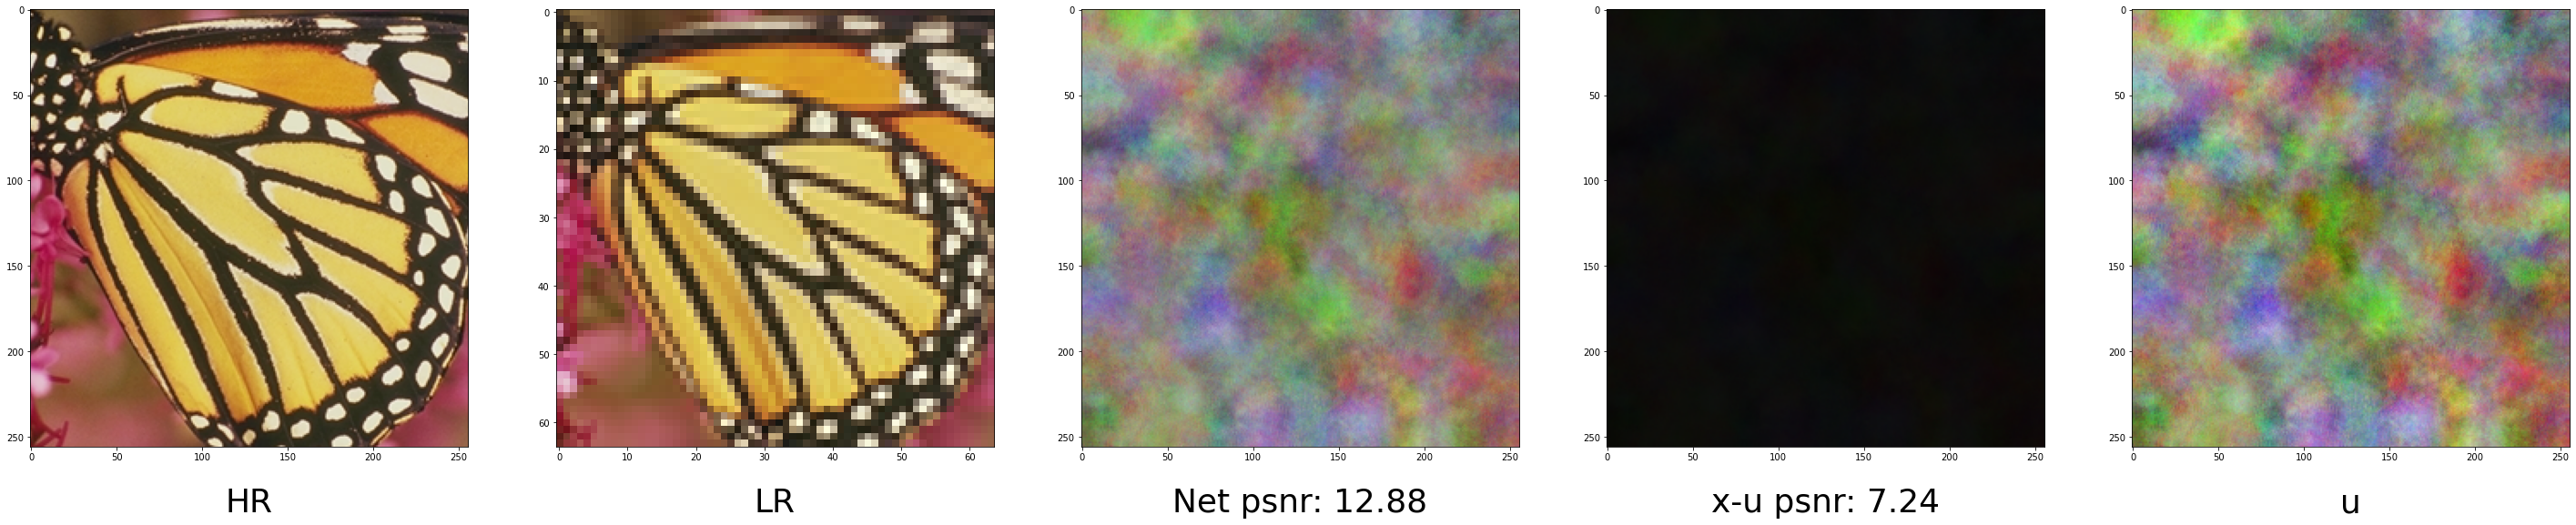

 DRED (BM3D) 0009/2000 Loss 0.052194 psnr net: 14.34 psnr x-u: 7.80

In [10]:
def run_and_plot(denoiser, name, plot_checkpoints={}):
    global data_dict
    # print:
    print("Ready to go, %s -> %s" % (data_dict[CORRUPTED].img.shape, data_dict[ORIGINAL].img.shape))
    # get net, input, and downsampler:
    net, net_input = get_network_and_input(img_shape=data_dict[ORIGINAL].img.shape)
    ds = Downsampler(n_planes=data_dict[CORRUPTED].img.shape[0], factor=FACTOR,
                 kernel_type='lanczos2', phase=0.5, preserve_size=True).type(dtype)
    # run the generic function:
    sr_img = train_via_admm(net, net_input, denoiser, ds, data_dict[CORRUPTED].img, data_dict[BICUBIC].img,
                            plot_array=plot_checkpoints, algorithm_name=name,
                            HR_img=data_dict[ORIGINAL].img)
    data_dict[name] = Data(sr_img, compare_PSNR(data_dict[ORIGINAL].img, sr_img, on_y=True))
    plot_dict(data_dict)


plot_checkpoints = {1, 10, 100, 1000, 1500}
run_and_plot(bm3d, DIP_BM3D, plot_checkpoints)